# Deep Learning Challenge
## Michelle Rohrer

### Pakete laden

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Daten laden und vorbereiten
Die Daten wurden von kaggle heruntergeladen (https://www.kaggle.com/datasets/msambare/fer2013)

Infos zu den Daten:

Die Daten bestehen aus 48x48 Pixel großen Graustufenbildern von Gesichtern. Die Gesichter wurden automatisch so ausgerichtet, dass sie mehr oder weniger zentriert sind und ungefähr den gleichen Bereich in jedem Bild einnehmen.

Die Aufgabe besteht darin, jedes Gesicht anhand des im Gesichtsausdruck gezeigten Gefühls einer von sieben Kategorien zuzuordnen (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). Der Trainingssatz besteht aus 28.709 Beispielen und der öffentliche Testsatz aus 3.589 Beispielen.

In [3]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

In [4]:
img_size = 48
batch_size = 64

# Daten normalisieren -> Pixelwerte zwischen 0 und 1
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir,
                                             target_size=(img_size, img_size),
                                             batch_size=batch_size,
                                             class_mode='categorical')
test_generator = datagen.flow_from_directory(test_dir,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            class_mode='categorical')

print(f"Klassen: {train_generator.class_indices}")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


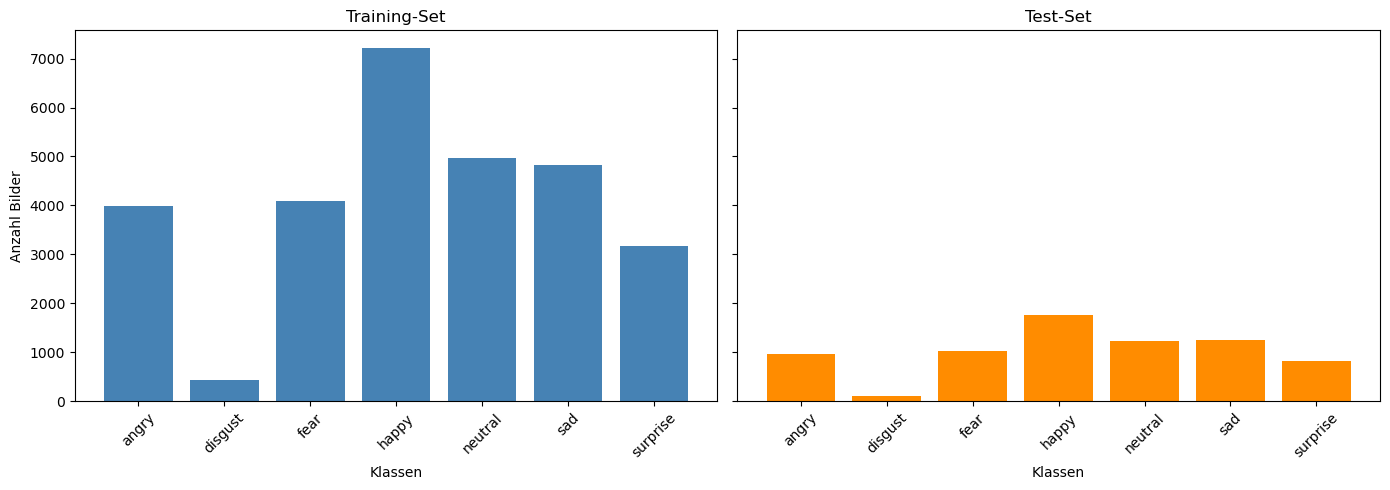

In [16]:
# Barplot mit der Verteilung der Klassen
labels, counts = zip(*[(k, v) for k, v in train_generator.class_indices.items()])
class_counts = [len(train_generator.filepaths) for c in counts]
train_labels = train_generator.classes  # numerische Klassenlabels für alle Trainingsbilder
train_df = pd.Series(train_labels).value_counts().sort_index()
class_names = list(train_generator.class_indices.keys())

labels, counts = zip(*[(k, v) for k, v in test_generator.class_indices.items()])
class_counts = [len(test_generator.filepaths) for c in counts]
test_labels = test_generator.classes  # numerische Klassenlabels für alle Trainingsbilder
test_df = pd.Series(test_labels).value_counts().sort_index()
class_names = list(test_generator.class_indices.keys())

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Training-Set
axes[0].bar(class_names, train_df.values, color="steelblue")
axes[0].set_title("Training-Set")
axes[0].set_xlabel("Klassen")
axes[0].set_ylabel("Anzahl Bilder")
axes[0].tick_params(axis='x', rotation=45)

# Test-Set
axes[1].bar(class_names, test_df.values, color="darkorange")
axes[1].set_title("Test-Set")
axes[1].set_xlabel("Klassen")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

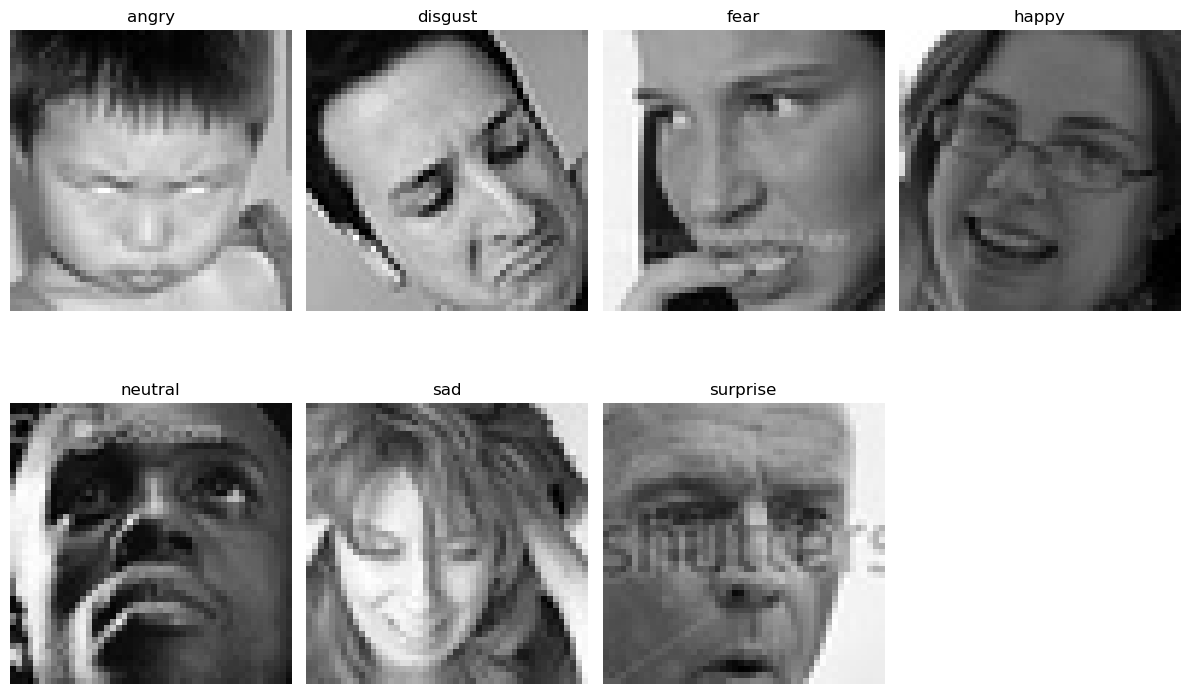

In [15]:
# Beispielbild 
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    # Index des ersten Bildes mit dieser Klasse finden
    idx = np.where(train_generator.classes == train_generator.class_indices[class_name])[0][0]
    img_path = train_generator.filepaths[idx]

    # Bild laden
    img = plt.imread(img_path)

    # Bild anzeigen in Grau
    plt.subplot(2, 4, i+1) 
    plt.imshow(img, cmap="gray")
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()